In [3]:
import sys
import warnings
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

from pbmc_helper import load_dex_genes

sys.path.append('..')
sys.path.append('/Users/lciernik/Documents/TUB/projects/ans_scoring/ANS_supplementary_information')
from data.load_data import load_datasets

from comparable_score_ranges_old import (
    score_signatures_with_all_methods,
    label_assignment_from_scores,
    get_lbl_assignment_performance,
    get_information_quantity_from_scores,
    remove_overlapping_signature_genes,
    get_violin_all_methods,
    prepare_data_for_violin_plot,
    plot_confusion_matrix
)

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'pdf.fonttype': 42, 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'font.size': 10})

Storing information and global variables

In [4]:
remove_overlapping_genes = True

SAVE = False
storing_path = Path('/Users/lciernik/Documents/TUB/projects/ans_scoring/results/citeseq/cd4_subtypes')

if remove_overlapping_genes:
    storing_path = storing_path / 'signatures_without_overlapping'
else:
    storing_path = storing_path / 'signatures_with_overlapping'

if SAVE:
    storing_path.mkdir(parents=True, exist_ok=True)

Loading data

In [5]:
adata = load_datasets('pbmc_cd4_subtypes')
adata

AnnData object with n_obs × n_vars = 39221 × 10898
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_names', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    layers: 'counts'

In [6]:
y_true_col = 'celltype.l2'
sample_col = 'orig.ident'

In [7]:
adata.obs[y_true_col].value_counts().sort_index()

CD4 CTL               1559
CD4 Naive            17228
CD4 Proliferating       30
CD4 TCM              14052
CD4 TEM               3913
Treg                  2439
Name: celltype.l2, dtype: int64

Computing dimensionality reduction

In [8]:
# sc.tl.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

Load signatures

In [9]:
DE_of_celltypes = load_dex_genes(filter_genes=True, threshold_pval=0.01, threshold_log2fc=0.5)

Shape DEX genes BEFORE filtering (11811, 4)
Shape DEX genes AFTER filtering (6288, 4)


In [10]:
subtypes_per_cell_type = adata.obs.groupby('celltype.l2')['celltype.l3'].apply(lambda x: list(x.unique()))

In [11]:
subtypes_per_cell_type.to_dict()

{'CD4 CTL': ['CD4 CTL'],
 'CD4 Naive': ['CD4 Naive'],
 'CD4 Proliferating': ['CD4 Proliferating'],
 'CD4 TCM': ['CD4 TCM_1', 'CD4 TCM_3', 'CD4 TCM_2'],
 'CD4 TEM': ['CD4 TEM_3', 'CD4 TEM_1', 'CD4 TEM_2', 'CD4 TEM_4'],
 'Treg': ['Treg Naive', 'Treg Memory']}

In [9]:
signatures = {}
for row in subtypes_per_cell_type.items():
    cell_type, subtypes = row
    signatures[cell_type] = sorted(
        list(set(DE_of_celltypes[DE_of_celltypes['Cell Type'].isin(subtypes)]['Gene'].tolist())))

In [10]:
for k, v in signatures.items():
    print(k, len(v))

CD4 CTL 41
CD4 Naive 92
CD4 Proliferating 465
CD4 TCM 100
CD4 TEM 58
Treg 71


In [11]:
if remove_overlapping_genes:
    signatures = remove_overlapping_signature_genes(signatures)

Removed {'TMSB4X', 'MAL', 'RPL34', 'RPS8', 'RPS25', 'FOXP1', 'CNN2', 'CD3D', 'RGS10', 'RPS29', 'HINT1', 'EEF1B2', 'CD3E', 'GBP2', 'SYNE2', 'RPL10', 'NPM1', 'PDE4D', 'LAT', 'MAF', 'RPS20', 'ACTG1', 'RPL5', 'RPS5', 'ARHGDIB', 'RPS27', 'FAM107B', 'RPL30', 'GMFG', 'TPT1', 'RPL21', 'RPL11', 'ZFP36L2', 'LTB', 'GZMA', 'RPL18', 'NOP53', 'SARAF', 'OCIAD2', 'RPL32', 'RPL13A', 'SPOCK2', 'TCF7', '6-Sep', 'RPL24', 'ARID5B', 'PPP2R5C', 'RPS12', 'MZT2A', 'ITM2A', 'CD69', 'RPS3', 'GIMAP7', 'RPL39', 'RPL13', 'ETS1', 'YWHAQ', 'RPL10A', 'CD27', 'PFN1', 'LDHB', 'GIMAP4', 'IL32', 'RPL3', 'ITGB1', 'CD28', 'LEPROTL1', 'RPL9', 'RPS3A', 'RPS10', 'C12orf75', 'RPL37', 'RPS28', 'IL2RG', 'CD2', 'SUB1', 'KLRB1', 'AES', 'CD3G', 'LIMS1', 'S1PR4', 'ARL4C', 'RCAN3', 'RORA', 'LYAR', 'RPL12', 'RPS15A', 'CORO1B', 'IL7R', 'CCL5', 'RPS27A', 'C12orf57', 'CD52', 'NOSIP', 'RPS6', 'RPL7', 'LEF1', 'CD99', 'RPL35A', 'RPLP2', 'RPS13', 'RPL38', 'UCP2', 'RPL36', 'RPS26', 'LCK', 'TRAC', 'HSPA8', 'RPS16', 'AQP3', 'RPS21', 'RPSA', 'TMS

In [12]:
order_signatures = ['CD4 Naive', 'CD4 TCM', 'CD4 TEM', 'CD4 CTL', 'CD4 Proliferating', 'Treg']

Scoring signatures

In [13]:
score_cols, adata = score_signatures_with_all_methods(adata, signatures, verbose=True)

Scoring CD4 CTL with adjusted_neighborhood_scoring
Scoring CD4 CTL with seurat_scoring
Scoring CD4 CTL with seurat_ag_scoring
Scoring CD4 CTL with seurat_lvg_scoring
Scoring CD4 CTL with scanpy_scoring
Scoring CD4 CTL with jasmine_scoring
Scoring CD4 CTL with jasmine_scoring
Scoring CD4 CTL with ucell_scoring
Scoring CD4 Naive with adjusted_neighborhood_scoring
Scoring CD4 Naive with seurat_scoring
Scoring CD4 Naive with seurat_ag_scoring
Scoring CD4 Naive with seurat_lvg_scoring
Scoring CD4 Naive with scanpy_scoring
Scoring CD4 Naive with jasmine_scoring
Scoring CD4 Naive with jasmine_scoring
Scoring CD4 Naive with ucell_scoring
Scoring CD4 Proliferating with adjusted_neighborhood_scoring
Scoring CD4 Proliferating with seurat_scoring
Scoring CD4 Proliferating with seurat_ag_scoring
Scoring CD4 Proliferating with seurat_lvg_scoring
Scoring CD4 Proliferating with scanpy_scoring
Scoring CD4 Proliferating with jasmine_scoring
Scoring CD4 Proliferating with jasmine_scoring
Scoring CD4 Prol

Label assignment

In [14]:
all_cols = []
label_cols = {}
for method_name, method_scores in score_cols.items():
    adata, new_lbl_col = label_assignment_from_scores(adata, method_name, method_scores, include_undefined=False)
    label_cols[method_name] = new_lbl_col
    all_cols += method_scores + [new_lbl_col]

Visualizing results

In [15]:
# fig = sc.pl.umap(adata, color=all_cols + [sample_col, y_true_col, 'celltype.l1', 'celltype.l3'],
#                  ncols=len(signatures) + 1, return_fig=True)
# save_close_or_show(fig, SAVE, storing_path / 'umap.pdf')

In [16]:
df_melted = prepare_data_for_violin_plot(adata, y_true_col, score_cols)

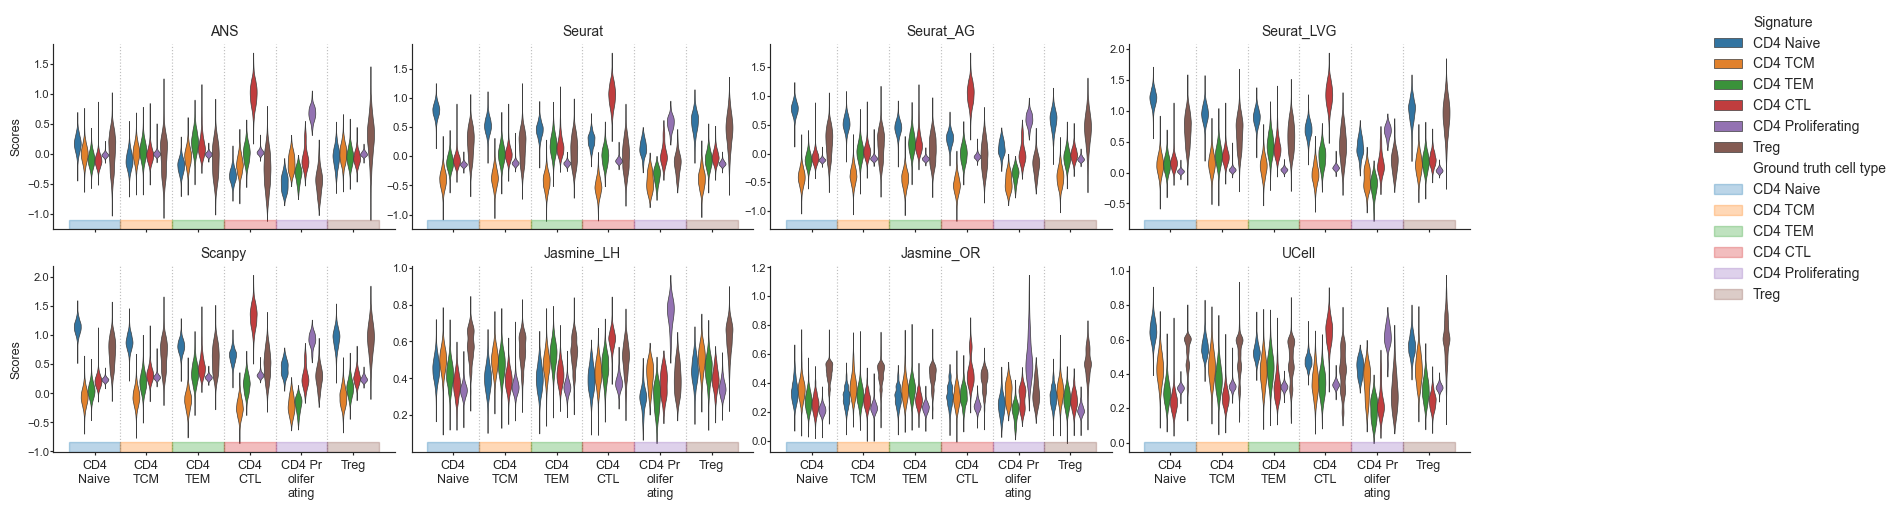

In [17]:
fig = get_violin_all_methods(df_melted, y_true_col, hue_order=order_signatures, textwrap_width=6, height=2.5,
                             aspect=1.5)
# save_close_or_show(fig, SAVE, storing_path/"violin_all_methods.pdf")
plt.show(fig)

In [18]:
# for method_name, method_scores in score_cols.items():
#     df = adata.obs.loc[:, method_scores + [y_true_col]]
#     fig = get_violin(df, method_scores, y_true_col)
#     plt.title(f"{method_name}")
#     save_close_or_show(fig, SAVE, storing_path / f'violin_{method_name}.pdf')

Computing label assignment performance

In [19]:
metrics = defaultdict(dict)
nfold = 10

for method_name, method_scores in score_cols.items():
    lbl_col = label_cols[method_name]
    conf_mat, bal_acc, f1_val, jacc_score = get_lbl_assignment_performance(adata,
                                                                           y_true_col=y_true_col,
                                                                           y_pred_col=lbl_col,
                                                                           label_names=order_signatures)

    scores = get_information_quantity_from_scores(
        adata,
        y_true_col=y_true_col,
        scores=method_scores,
        nfold=nfold,
    )

    metrics[method_name] = {
        'hard_lbl_conf_mat': conf_mat,
        'hard_lbl_balanced_accuracy': bal_acc,
        'hard_lbl_f1_score': f1_val,
        'hard_lbl_jaccard_score': jacc_score,
    }

    for metric, mean_std in scores.items():
        for k, v in mean_std.items():
            new_key = f"logreg_{metric}_{k}"
            metrics[method_name][new_key] = v

    fig = plot_confusion_matrix(conf_mat, order_signatures, method_name, figsize=(4, 4), textwrap_width=7,
                                xrotation=45, cbar=False)
    plt.close(fig)
    # save_close_or_show(fig, SAVE, storing_path / f'conf_mat_{method_name}.pdf')

In [20]:
metrics_df = pd.DataFrame(metrics)
metrics_df.T

,conf_mat,balanced_accuracy,f1_score,jaccard_score,logreg_f1_weighted_mean,logreg_f1_weighted_std,logreg_balanced_accuracy_mean,logreg_balanced_accuracy_std,logreg_jaccard_weighted_mean,logreg_jaccard_weighted_std
ANS,"[[0.5048177385651266, 0.1040747620153239, 0.03...",0.645441,0.456836,0.313877,0.734777,0.006521,0.682098,0.021712,0.609725,0.007946
Seurat,"[[0.988449036452287, 0.0, 0.0, 5.8045042953331...",0.561628,0.362449,0.26801,0.747197,0.005962,0.684433,0.02712,0.625449,0.006855
Seurat_AG,"[[0.9914673786858602, 0.0, 0.0, 5.804504295333...",0.557947,0.360978,0.26656,0.749187,0.005952,0.692433,0.022631,0.62739,0.006609
Seurat_LVG,"[[0.9792779196656606, 0.0, 0.0, 5.804504295333...",0.538759,0.351799,0.265304,0.749202,0.005343,0.690623,0.022029,0.628267,0.006087
Scanpy,"[[0.9569305781286278, 0.0, 0.0, 5.804504295333...",0.570375,0.353718,0.267389,0.743977,0.005236,0.684696,0.028134,0.620214,0.005729
Jasmine_LH,"[[0.04173438588344555, 0.1918969120037149, 0.0...",0.551022,0.215701,0.134246,0.608693,0.006492,0.58078,0.028167,0.465822,0.006256
Jasmine_OR,"[[0.10825400510796378, 0.12851172509867656, 0....",0.486816,0.255434,0.151781,0.567558,0.005216,0.541055,0.025207,0.41585,0.005403
UCell,"[[0.8754933828651034, 0.010912468075226375, 5....",0.600386,0.447945,0.332048,0.721152,0.005324,0.666346,0.026985,0.588569,0.006356


In [21]:
from sklearn.metrics import f1_score, balanced_accuracy_score, jaccard_score
from signaturescoring.scoring_methods.gmm_postprocessing import GMMPostprocessor


def get_gmm_perf(adata, curr_score_names, y, K=3):
    gmm_post = GMMPostprocessor(n_components=K)

    store_name_pred, store_names_proba, _ = gmm_post.fit_and_predict(
        adata, curr_score_names
    )
    assignments = gmm_post.assign_clusters_to_signatures(
        adata, curr_score_names, store_names_proba, plot=False
    )
    gmm_cols = []
    for key, val in assignments.items():
        if key == "rest":
            sc.logging.warning(
                f"Couldn't could find correct GMM cluster and signature mapping. Skipping {curr_score_names} is adviced"
            )
            continue
        adata.obs[key + "_gmm"] = adata.obs[val].copy()
        gmm_cols.append(key + "_gmm")

    y_pred = adata.obs[gmm_cols].idxmax(axis=1)
    y_pred = (y_pred.apply(lambda x: x.rsplit("_", 2)[1])).values
    sc.settings.verbosity = 2

    return (
        f1_score(y, y_pred, average="weighted"),
        balanced_accuracy_score(y, y_pred),
        jaccard_score(y, y_pred, average="weighted"),
    )


get_gmm_perf(adata, score_cols['ANS'], adata.obs[y_true_col].values, K=adata.obs[y_true_col].nunique())

/Users/lciernik/miniforge3/envs/ans_scoring/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


(0.0, 0.0, 0.0)

Saving performance metrics

In [ ]:
if SAVE:
    metrics_df.to_csv(storing_path / 'metrics.csv')
    print(f"Saved metrics to {storing_path / 'metrics.csv'}.")